# Computer Vision project: Singapore Traffic Rates

Hypothesis:
- Traific was signifigantly affected by the covid pandemic in Singapore

Test Method:
- Computer Vision and CNN to understand the traffic flow automatically 

Goals:
- To explore API, and leverage it to make large datasets
- Map locations of  the camera we are pulling the data from
- Indentify the best location for collect the data most relvent to our project



**--- PART 1 ---**

In [ ]:
# Installing the required libraries

# --- RUN  ON START UP --- #
!pip install geopandas
!pip install cython
!pip install cartopy
!pip install geoplot

In [ ]:
import requests #handling api calls
import pandas as pd # data manipulation
import geopandas as gpd # geo data manipulation
import matplotlib.pyplot as plt
import geoplot as gplt
import datetime
import time


API request

In [ ]:
# calling the api
response = requests.get('https://api.data.gov.sg/v1/transport/traffic-images?date_time=2019-01-01T12%3A00%3A00')
# tranforming the response to with json reader method
data = response.json()
print(data)

{'items': [{'timestamp': '2019-01-01T11:59:57+08:00', 'cameras': [{'timestamp': '2019-01-01T11:59:37+08:00', 'image': 'https://images.data.gov.sg/api/traffic-images/2019/01/8101fdc6-9848-4830-af5d-c1c9a716c462.jpg', 'location': {'latitude': 1.27414394350065, 'longitude': 103.851316802547}, 'camera_id': '1501', 'image_metadata': {'height': 240, 'width': 320, 'md5': 'b4e2752965b2574e46772e1e6966af4b'}}, {'timestamp': '2019-01-01T11:59:37+08:00', 'image': 'https://images.data.gov.sg/api/traffic-images/2019/01/c0456723-b36d-4a52-878a-0d38e4046efb.jpg', 'location': {'latitude': 1.27135090682664, 'longitude': 103.861828440597}, 'camera_id': '1502', 'image_metadata': {'height': 240, 'width': 320, 'md5': '8315be83c1481a86f495406c8c8d8e14'}}, {'timestamp': '2019-01-01T11:59:37+08:00', 'image': 'https://images.data.gov.sg/api/traffic-images/2019/01/b1ae02ea-37ca-42fd-aa6b-7e23252f3e57.jpg', 'location': {'latitude': 1.27066408655104, 'longitude': 103.856977943394}, 'camera_id': '1503', 'image_met

We are interested in:
 

*   camera_id -- nested in an array of cameras inside of  camera key
*   image: a URL that has the image of what the camera is seeing at that time
*   location: gps cords for the camera, nested in the camera object

In [ ]:
# Normalizing the JSON response
camera_df = pd.json_normalize(data['items'], 'cameras')
print(camera_df)
# Renaming longitude and latitude
camera_df = camera_df.rename(columns={'location.latitude':'latitude', 'location.longitude': 'longitude'})

                    timestamp  ...                image_metadata.md5
0   2019-01-01T11:59:37+08:00  ...  b4e2752965b2574e46772e1e6966af4b
1   2019-01-01T11:59:37+08:00  ...  8315be83c1481a86f495406c8c8d8e14
2   2019-01-01T11:59:37+08:00  ...  958c9e3c3384836b46c0ee379d837a9d
3   2019-01-01T11:59:37+08:00  ...  2bcda18da47b85dce997a7e84897d04c
4   2019-01-01T11:59:37+08:00  ...  2dc228f314f08645a2ad856a302f0e00
..                        ...  ...                               ...
82  2019-01-01T11:58:17+08:00  ...  5e9c8b7f93ae98388e4635c96bffec0a
83  2019-01-01T11:58:17+08:00  ...  6104a423f33180a72e1d19ed2537c0ac
84  2019-01-01T11:58:17+08:00  ...  736d8a0d91c1dd8d325a2a79e7e54ed8
85  2019-01-01T11:56:37+08:00  ...  50f2c5b729050b2bda2b00a8612b4a8f
86  2019-01-01T11:56:37+08:00  ...  77ec6123cbe2ef323286de9514a66cca

[87 rows x 8 columns]


The next step is to load in the shape file, this is the geospacial(map) profile for the singapore planning development.

In [ ]:
# parsing the data with geopandas
SHP_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/ComputerVision/Area-boundry/MP14_PLNG_AREA_NO_SEA_PL.shp')

Addressing the format of the cooridates using geoPandas


In [ ]:
# converting the coords to long and lat
shp_df = SHP_df.to_crs('EPSG:4326')

To use the coorids, need to convert the data in the orginal df to something geoPandas likes.

** **

**Geo needs a few things to do this**


*   x and y coorids 
*   A column to dump the conversion in



In [ ]:
# getting a geopandas dataframe from the json response
camera_loc = gpd.GeoDataFrame( camera_df, geometry = gpd.points_from_xy(camera_df.longitude, camera_df.latitude))

# printing
print(camera_loc)

                    timestamp  ...                   geometry
0   2019-01-01T11:59:37+08:00  ...  POINT (103.85132 1.27414)
1   2019-01-01T11:59:37+08:00  ...  POINT (103.86183 1.27135)
2   2019-01-01T11:59:37+08:00  ...  POINT (103.85698 1.27066)
3   2019-01-01T11:59:37+08:00  ...  POINT (103.87606 1.29410)
4   2019-01-01T11:59:37+08:00  ...  POINT (103.86639 1.27530)
..                        ...  ...                        ...
82  2019-01-01T11:58:17+08:00  ...  POINT (103.90539 1.36352)
83  2019-01-01T11:58:17+08:00  ...  POINT (103.90204 1.35710)
84  2019-01-01T11:58:17+08:00  ...  POINT (103.63504 1.34870)
85  2019-01-01T11:56:37+08:00  ...  POINT (103.87115 1.29531)
86  2019-01-01T11:56:37+08:00  ...  POINT (103.98032 1.33831)

[87 rows x 9 columns]


Time to visualize the map of camera on a map of singapore


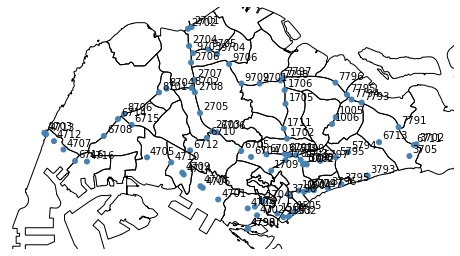

In [ ]:
# using geoplot -- first plot the map from the shp file as a polygon 
ax = gplt.polyplot(shp_df)

# now plot the locations of the cameras in our data set as points
gplt.pointplot(camera_loc, ax=ax)

# now to label the points on the map
for x, y, label in zip(camera_loc.geometry.x, camera_loc.geometry.y, camera_loc.camera_id):
  # the for loop grabs the location x, location y, and id
  ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

****
# Done on a seperate ***workbook***
****
*   First: Handle the api calls
*   Second: Set up the date ranges we want
*   Third: setup workers to call api multiple times at once



*****
We then use the JSON data to requeset the images for the cameras that we care about
*****
* Sort response by camera ID
* Use the stored image URL in image URL columns and download the image
*  Download images and store them in the my drive
*****
Function for doing this can be seen in this cell:
https://colab.research.google.com/drive/16o9g0yWYeEN_8IP52UHEefp5OjNFTkU_#scrollTo=9iUToi1iVJPl&line=19&uniqifier=1

******



*****
# Classifying Traffic with OpenCV
*****
Using images collected in the last step, the image is passed to openCV

- First: image is taken in as an array of values through cv2 imread
- Second: Using yolov4 weights, cv detect common images was passed the image array
- Third: counts were recorded for each image and stored within a seperate df
***** 
**Final** step! Putting all the data collection together!
*****

In [2]:
# importing the necessary libraries!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

Reading in data


In [3]:
# Reading in the labels of the data
c1702_2019Labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ComputerVision/resp_2019_c_id1702_labels.csv', index_col=0)
c1702_2020Labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ComputerVision/resp_2020_c_id1702_labels.csv', index_col=0)
c1702_2021Labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ComputerVision/resp_2021_c_id1702_labels.csv', index_col=0)
# Reading in the orginal df we made request from
c1702_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ComputerVision/resp_2019_c_id1702.csv',index_col=0, parse_dates = True)
c1702_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ComputerVision/resp_2020_c_id1702.csv',index_col=0, parse_dates = True)
c1702_2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ComputerVision/resp_2021_c_id1702.csv',index_col=0, parse_dates = True)

Adding the labels to main df

In [4]:
# Replacing non recorded values with zer0 because we dont have the information
c1702_2019Labels.replace('NaN', 0, inplace=True)
c1702_2020Labels.replace('NaN', 0, inplace=True)
c1702_2021Labels.replace('NaN', 0, inplace=True)
# setting the last colum
c1702_2019['num_cars'] = c1702_2019Labels.values
c1702_2020['num_cars'] = c1702_2020Labels.values
c1702_2021['num_cars'] = c1702_2021Labels.values

In [5]:
# changing the data strings to dateTime
dateTimes = []
# 2019
for items in c1702_2019['timestamp']:
    dateTimes.append(pd.to_datetime(items, utc=False))
c1702_2019['timestamp'] = dateTimes

# 2020
dateTimes = []
for items in c1702_2020['timestamp']:
    dateTimes.append(pd.to_datetime(items))
c1702_2020['timestamp'] = dateTimes
# 2021
dateTimes = []
for items in c1702_2021['timestamp']:
    dateTimes.append(pd.to_datetime(items))
c1702_2021['timestamp'] = dateTimes

In [6]:
c1702_2019.set_index('timestamp')
c1702_2020.set_index('timestamp')
c1702_2021.set_index('timestamp')

,image,camera_id,location.latitude,location.longitude,image_metadata.height,image_metadata.width,image_metadata.md5,num_cars
timestamp,,,,,,,,
2021-03-01 00:57:51+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,3a5368674949e04b9dc532b5e964b5da,4
2021-03-01 01:00:51+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,ae12a1f8f6efb8d1f303c1cd3e80fd59,1
2021-03-01 01:03:51+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,d5fae0f26193ac9ad4798b4cdd5fc054,4
2021-03-01 01:06:51+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,70cbd70ff15287635eb030229855ec28,1
2021-03-01 01:09:51+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,c95879aeca35e7d270f866e74ab55f8d,2
...,...,...,...,...,...,...,...,...
2021-04-30 12:47:45+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,ecad4715ad9e09e3a3108a3943d9b361,10
2021-04-30 12:50:45+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,e8fbf95d14d304a648a7cc75dc26bc6a,8
2021-04-30 12:53:25+08:00,https://images.data.gov.sg/api/traffic-images/...,1702,1.34355,103.860198,480,640,d604d8598e2008c06afde1603bb997d9,8


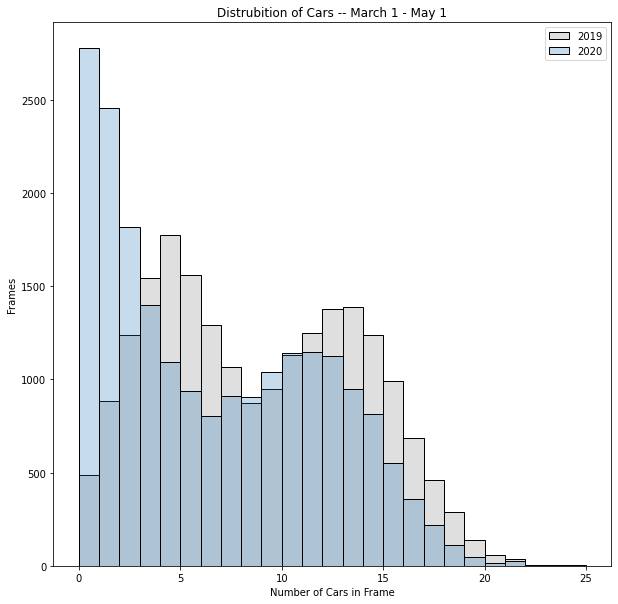

In [7]:
# Plotting the distrubtion of the num_cars
fig = plt.figure(figsize=(10,10))
bins =  c1702_2019['num_cars'].max()
ax = sns.histplot(x='num_cars', data=c1702_2019, bins =bins, color='grey', alpha = .25)
bins = int( c1702_2020['num_cars'].max())
ax1 = sns.histplot(x='num_cars', data=c1702_2020, bins =bins, alpha=.25)
ax.legend([2019,2020])
ax.set_title('Distrubition of Cars -- March 1 - May 1')
ax.set_xlabel('Number of Cars in Frame')
ax.set_ylabel('Frames')
plt.show(ax,ax1)

# Resample time!

In [28]:
# Resampling by day
#2019
re2019 = pd.Series(c1702_2019.num_cars.values,c1702_2019.timestamp.dt.to_pydatetime())
c1702_resample_2019 =re2019.resample('1D').median()
c1702_resample_2019.drop(c1702_resample_2019.tail(1).index,inplace=True)
print(c1702_resample_2019)
re2020 = pd.Series(c1702_2020.num_cars.values,c1702_2020.timestamp.dt.to_pydatetime())
c1702_resample_2020 =re2020.resample('1D').median()
c1702_resample_2020.drop(c1702_resample_2020.tail(1).index,inplace=True)
print(c1702_resample_2020)
re2021 = pd.Series(c1702_2021.num_cars.values,c1702_2021.timestamp.dt.to_pydatetime())
c1702_resample_2021 = re2021.resample('1D').median()
c1702_resample_2021_sum = re2021.resample('1D').sum()
c1702_resample_2021.drop(c1702_resample_2021.tail(1).index,inplace=True)
print(c1702_resample_2021)

2019-03-01 00:00:00+08:00    8.0
2019-03-02 00:00:00+08:00    8.5
2019-03-03 00:00:00+08:00    7.0
2019-03-04 00:00:00+08:00    9.0
2019-03-05 00:00:00+08:00    8.0
                            ... 
2019-04-26 00:00:00+08:00    8.5
2019-04-27 00:00:00+08:00    9.0
2019-04-28 00:00:00+08:00    9.0
2019-04-29 00:00:00+08:00    9.0
2019-04-30 00:00:00+08:00    9.0
Freq: D, Length: 61, dtype: float64
2020-03-01 00:00:00+08:00     6.0
2020-03-02 00:00:00+08:00     8.0
2020-03-03 00:00:00+08:00     8.0
2020-03-04 00:00:00+08:00     8.0
2020-03-05 00:00:00+08:00     9.0
                             ... 
2020-04-26 00:00:00+08:00     2.0
2020-04-27 00:00:00+08:00     5.0
2020-04-28 00:00:00+08:00    10.0
2020-04-29 00:00:00+08:00     4.0
2020-04-30 00:00:00+08:00     5.0
Freq: D, Length: 61, dtype: float64
2021-03-01 00:00:00+08:00    6.0
2021-03-02 00:00:00+08:00    5.5
2021-03-03 00:00:00+08:00    5.0
2021-03-04 00:00:00+08:00    5.5
2021-03-05 00:00:00+08:00    7.0
                          

Text(-50, -100, 'Circuit Breaker')

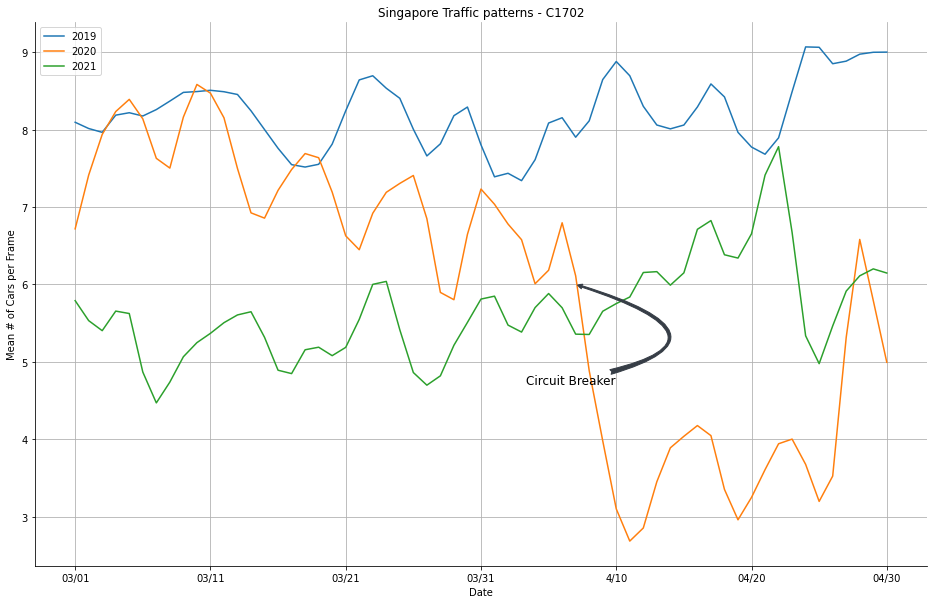

In [49]:
# making a graph of the trends
from scipy.ndimage import gaussian_filter as gf

fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(gf(c1702_resample_2019.values, sigma=1))
ax.plot(gf(c1702_resample_2020.values, sigma=1))
ax.plot(gf(c1702_resample_2021.values, sigma=1))
ax.legend(['2019','2020','2021'])
ax.set_xticklabels(['', '03/01', '03/11', '03/21', '03/31', '4/10', '04/20', '04/30'])
ax.set_ylabel('Mean # of Cars per Frame')
ax.set_xlabel('Date')
ax.set_title("Singapore Traffic patterns - C1702")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid('on')
ax.annotate('Circuit Breaker',
            xy=(37, 6),
            xycoords='data',
            xytext=(-50,-100),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy", color='#363d46', connectionstyle="arc3,rad=2"),
            fontsize=12)